# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2 as cv



# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_37678/866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


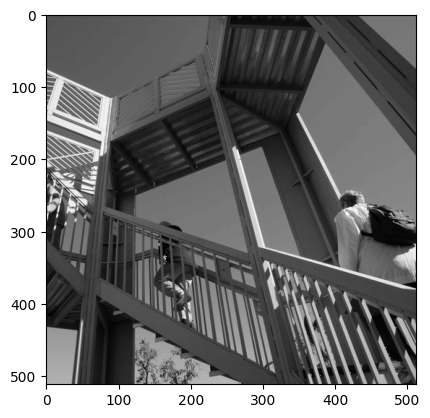

In [3]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

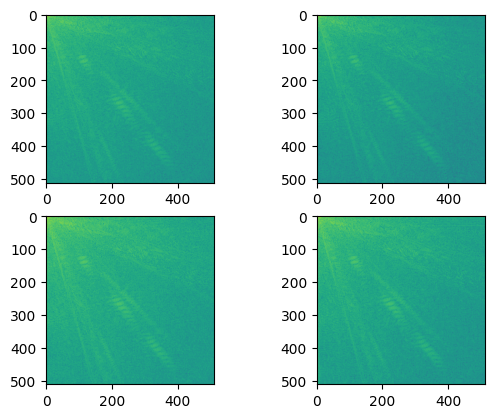

In [4]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

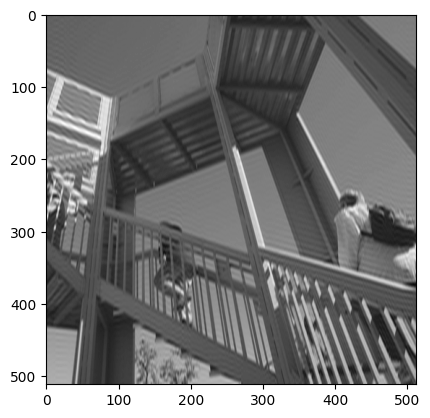

In [5]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_37678/2937983476.py:11: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()


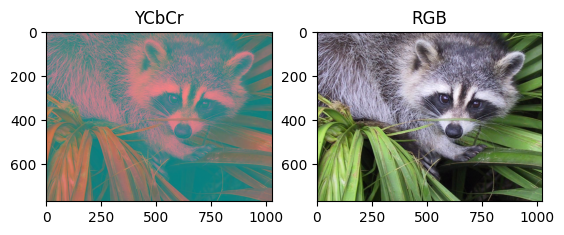

In [6]:
# Step 1. Color Transformations
# RGB to Y'CbCr 
def rgb_to_ycbcr(img):
    return cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)


# Y'CbCr to RGB
def ycbcr_to_rgb(img):
    return cv.cvtColor(img, cv.COLOR_YCR_CB2RGB)

img = misc.face()
imgYcbcr = rgb_to_ycbcr(img)
imgRgb = ycbcr_to_rgb(imgYcbcr)

# Plot
plt.subplot(121).imshow(imgYcbcr)
plt.title('YCbCr')
plt.subplot(122).imshow(imgRgb)
plt.title('RGB')
plt.show()

X = imgYcbcr

In [7]:
Q_jpeg_Y = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

Q_jpeg_CbCr = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                         [18, 21, 26, 66, 99, 99, 99, 99],
                         [24, 26, 56, 99, 99, 99, 99, 99],
                         [47, 66, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99],
                         [99, 99, 99, 99, 99, 99, 99, 99]])
pragMSE = 120

In [8]:
# Step 2. Applying 2D-DCT
def dctnTransf(block):
    return dctn(block)

def idctnTransf(block):
    return idctn(block)

In [9]:
# Step 3. Quantization
def quantization(block):
    return np.round(block / Q_jpeg_Y)

def reverseQuantization(block):
    return block * Q_jpeg_Y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


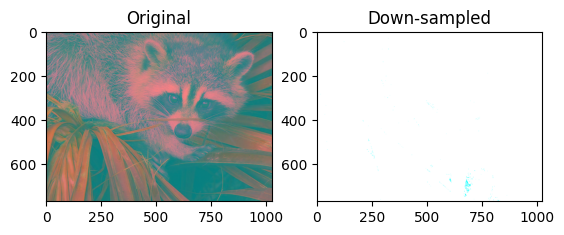

In [10]:

Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down)

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

In [89]:
# Block traversal in zig zag
def zigZag(block):
        zig_zag = []

        for diag in range(0, 14):
            i_range = range(0, diag + 1) if diag % 1 == 0 else range(diag, -1, -1)

            for i in i_range:
                if 0 <= i < 8 and 0 <= diag - i < 8:
                    zig_zag.append(block[i, diag - i])

        return zig_zag

def reverse_zigZag(zig_zag):
        # Get the zig-zag and return the block format  
        block = np.zeros((8, 8))

        for diag in range(0, 14):
            # order of traversal alternates
            i_range = range(0, diag + 1) if diag % 1 == 0 else range(diag, -1, -1)

            i_zigZag = 0
            for i in i_range:
                if 0 <= i < 8 and 0 <= diag - i < 8:
                    block[i, diag - i] = zig_zag[i_zigZag]
                    i_zigZag += 1

        return block



In [92]:
# Intermediate Symbol Sequence
def intermediate_symbol_sequence(zig_zag):
        # Represent zig-zag as a tuple: (runLength, amplitude)
        # runLength = num of Zeroes until the amplitude
        symbSeq = []
        runLength = 0

        for amplitude in zig_zag:
            if amplitude != 0:
                symbSeq.append((runLength, amplitude))
                runlegth = 0
            else:
                runlegth += 1

        # Check if all amplitudes are 0
        if len(symbSeq) == 0:
            symbSeq.append((63, 0))

        return symbSeq

def reverse_intermediate_symbol_sequence(symbSeq):  
        # Get the symbol sequence back to the zig-zag
        zig_zag = np.zeros(64)

        place = 0
        for runLength, amplitude in symbSeq:
            zig_zag[place + runLength] = amplitude # add the amplitude to the right place and leave 0 in the rest
            place = place + runLength + 1
        return zig_zag

In [13]:

# Calculate MSE
def calcMSE(oldImg, newImg):
    return np.mean((oldImg - newImg) ** 2)

In [20]:
def elimHighFreq(img, comp_f):
    for i in range(8):
        for j in range(8):
            if i + j >= 15 - comp_f:
                img[i, j] = 0  
    return img

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

In [134]:
# JPEG Compression for an image
def encodeJPEG(imgRgb, comp_f):
    shape0, shape1 = img.shape[0], img.shape[1]
    
    # RGB to Ycbcr
    imgYcbcr = rgb_to_ycbcr(imgRgb)
    channels = [imgYcbcr[:, :, 0], imgYcbcr[:, :, 1], imgYcbcr[:, :, 2]]

    y_jpeg =[[[0 for _ in range(shape1 // 8)] for _ in range(shape0 // 8)] for _ in range(3)]

    for ch_idx, channel in enumerate(channels):
        for i in range(0, shape0, 8):
            for j in range(0, shape1, 8):
                # Get Block
                y = channel[i:i + 8, j:j + 8] 

                # 2D-DCT Transformation
                dctn_y = dctnTransf(y)

                if ch_idx != 0 :
                    # Quantization
                    quantized_y = quantization(dctn_y)
                else :
                    quantized_y = dctn_y


                # Eliminate High Frequencies
                quantized_y = elimHighFreq(quantized_y, comp_f)
                
                # # Zig Zag
                # zigZag_y = zigZag(quantized_y)

                # # Intermediate Symbol Sequence
                # iss_y = intermediate_symbol_sequence(zigZag_y)
                iss_y = quantized_y

                # Rebuild Image
                y_jpeg[ch_idx][i // 8][j // 8] = iss_y

    return np.array(y_jpeg, dtype=object)


In [133]:
def decodeJPEG(img):
    shape0, shape1, shape2 = img.shape[0], img.shape[1], img.shape[2]
    y_orig = np.zeros((shape1 * 8, shape2 * 8, shape0), dtype=np.uint8)
    for ch_idx in range(shape0):
        for i in range(0, shape1):
            for j in range(0, shape2):
                
                # # Get ZigZag from Intermediate Symbol Sequence
                # zigZag_y = reverse_intermediate_symbol_sequence(img[ch_idx][i][j])
                
                # # Get Block from ZigZag
                # block_y = reverse_zigZag(zigZag_y)
                block_y = img[ch_idx][i][j]

                if ch_idx != 0:
                    # Reverse Quantization
                    quantized_y = reverseQuantization(block_y)
                else:
                    quantized_y = block_y


                # 2D-DCT Transformation
                y = idctnTransf(quantized_y)

                # Rebuild Image
                y_orig[i * 8 : (i + 1) * 8, j * 8 : (j + 1) * 8, ch_idx] = y

    # YCbCr to RGB
    # print(img)
    imgRgb = ycbcr_to_rgb(np.array(y_orig))
    return imgRgb

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_37678/3786337568.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()


0.9920056660970052


Text(0.5, 1.0, 'After Compression')

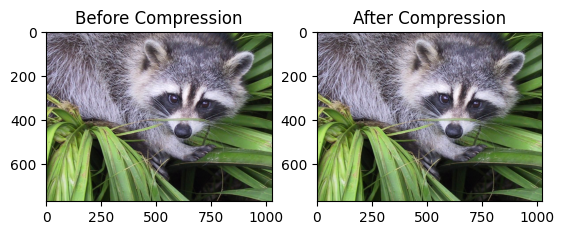

In [143]:
# Test
img = misc.face()
encodedImg = encodeJPEG(img, 0)
decodedImg = decodeJPEG(encodedImg)
print(calcMSE(img, decodedImg))

# Plot
plt.subplot(121).imshow(img)
plt.title('Before Compression')
plt.subplot(122).imshow(decodedImg)
plt.title('After Compression')

In [141]:
def compressMSE(img, mse):
    # Increase compression factor as much as possible 
    i = 0
    encodedImg = encodeJPEG(img, comp_f = i)
    decodedImg = decodeJPEG(encodedImg)
    new_mse = calcMSE(img, decodedImg)
    while new_mse <= mse:
        latest_compressed = encodedImg
        latest_mse = new_mse
        latest_factor = i

        # Increase factor
        i = i + 1
        encodedImg = encodeJPEG(img, comp_f = i)
        decodedImg = decodeJPEG(encodedImg)
        new_mse = calcMSE(img, decodedImg)

    print("MSE: " + str(latest_mse))
    print("Compression Factor: " + str(latest_factor))
    return latest_compressed

/var/folders/bv/zvc9tyns1vs10pzppsb3b4nw0000gn/T/ipykernel_37678/3125206821.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()


MSE: 69.82449467976888
Compression Factor: 14


Text(0.5, 1.0, 'After Compression')

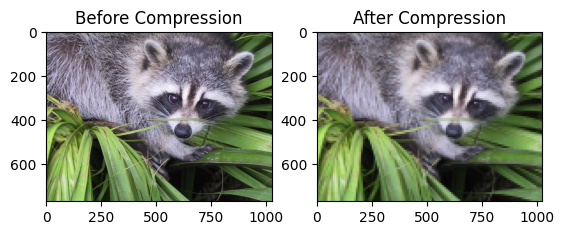

In [144]:
# Test with MSE
img = misc.face()
encodedImg = compressMSE(img, 100)
decodedImg = decodeJPEG(encodedImg)

# Plot
plt.subplot(121).imshow(img)
plt.title('Before Compression')
plt.subplot(122).imshow(decodedImg)
plt.title('After Compression')

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.